## Week 8: Reinforcement Learning for seq2seq

In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                # way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  # maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          # how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.



In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:

        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word,trans = (he,en) if MODE=='he-to-en' else (en,he)

        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue

        word_to_translation[word].append(trans)

print ("size = ",len(word_to_translation))

size =  130113


In [3]:
#get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [4]:
from sklearn.model_selection import train_test_split
train_words,test_words = train_test_split(all_words,test_size=0.1,random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0 119  12  49 187  88 101  46   1   1   1   1   1   1]
 [  0 119  19  86  88 101  46  56  85 157 119 145  88   1]
 [  0 119 157 176 132  19   1   1   1   1   1   1   1   1]
 [  0 119 157 176 142  50   1   1   1   1   1   1   1   1]
 [  0 119 187  88 157 145   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

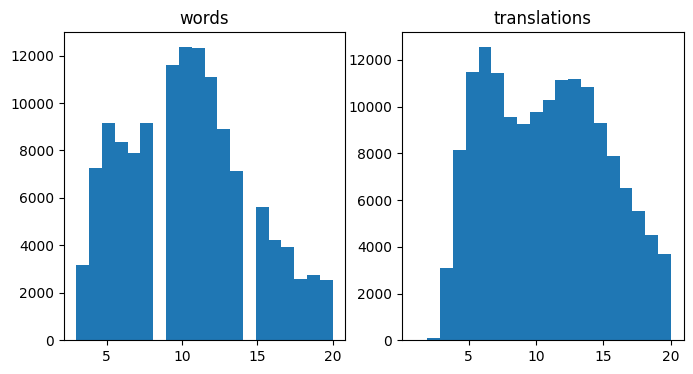

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=20);


### Step 3: deploy encoder-decoder (1 point)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
  * if given flag __`greedy=True`__, takes most likely next token at each iteration. Otherwise samples with next token probabilities predicted by model.

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
from basic_model_torch import BasicTranslationModel
model = BasicTranslationModel(inp_voc, out_voc,
                              emb_size=64, hid_size=256)

In [10]:
# Play around with symbolic_translate and symbolic_score
inp = Variable(torch.LongTensor(np.random.randint(0,10,[3,5])))
out = Variable(torch.LongTensor(np.random.randint(0,10,[3,5])))

# translate inp (with untrained model)
sampled_out, logp = model.translate(inp, greedy=False)

print("Sample translations:\n", sampled_out)
print("Log-probabilities at each step:\n",logp)

Sample translations:
 tensor([[  0, 254,  37,  ...,  18, 246,   1],
        [  0, 163,  26,  ..., 256,  66, 164],
        [  0, 185,  18,  ..., 190, 193,  57]])
Log-probabilities at each step:
 tensor([[[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.5906,  -5.5706,  -5.6825,  ...,  -5.6167,  -5.6678,  -5.7595],
         [ -5.6193,  -5.6674,  -5.6366,  ...,  -5.6579,  -5.5440,  -5.5913],
         ...,
         [ -5.6116,  -5.6532,  -5.4303,  ...,  -5.6912,  -5.8713,  -5.6701],
         [ -5.5118,  -5.6191,  -5.3987,  ...,  -5.6248,  -5.8342,  -5.7198],
         [ -5.6233,  -5.5719,  -5.4650,  ...,  -5.6610,  -5.6733,  -5.7325]],

        [[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.5890,  -5.5603,  -5.6733,  ...,  -5.6084,  -5.6628,  -5.7686],
         [ -5.6832,  -5.7196,  -5.6625,  ...,  -5.6643,  -5.5418,  -5.6620],
         ...,
         [ -5.5578,  -5.7596,  -5.5640,  ...,  -5.5224,  -5.7095,  -5.9069],
      

In [11]:
# score logp(out | inp) with untrained input
logp = model(inp, out)
print("Symbolic_score output:\n", logp)

print("Log-probabilities of output tokens:\n", torch.gather(logp, dim=2, index=out[:,:,None]))

Symbolic_score output:
 tensor([[[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.4794,  -5.6985,  -5.7507,  ...,  -5.6032,  -5.6999,  -5.7921],
         [ -5.4473,  -5.7390,  -5.7831,  ...,  -5.6229,  -5.7178,  -5.8214],
         [ -5.6477,  -5.6712,  -5.7644,  ...,  -5.4996,  -5.6417,  -5.8266],
         [ -5.5312,  -5.7567,  -5.7758,  ...,  -5.5828,  -5.6939,  -5.8402]],

        [[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.5269,  -5.6132,  -5.5927,  ...,  -5.4832,  -5.7823,  -5.7588],
         [ -5.6419,  -5.5971,  -5.6069,  ...,  -5.4335,  -5.7580,  -5.8271],
         [ -5.7125,  -5.5933,  -5.6591,  ...,  -5.3883,  -5.6479,  -5.8223],
         [ -5.6130,  -5.6165,  -5.5927,  ...,  -5.3948,  -5.7899,  -5.7816]],

        [[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.8076,  -5.8103,  -5.6619,  ...,  -5.6190,  -5.5813,  -5.7475],
         [ -5.5974,  -5.7814,  -5.7392,  ...,  -

In [12]:
def translate(lines, max_len=MAX_OUTPUT_LENGTH):
    """
    You are given a list of input lines.
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)
    lines_ix = Variable(torch.LongTensor(lines_ix))

    # Compute translations in form of indices
    # ***************************
    # мой код
    trans_ix = model.translate(lines_ix, greedy=True, max_len=max_len)[0]
    # ***************************

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix.data.numpy())


In [13]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))
trans = translate(all_words[:3])

assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
# note: if translation freezes, make sure you used max_len parameter
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ["ʿʿпրvļqóااتשש×いùùê'", "ʿʿпրvļqóااتשש×いùùê'", "ʿʿпրvļqóااتשש×いùùê'"]
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [14]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)

    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)

    distances = list(map(get_distance,batch_words,batch_trans))

    return np.array(distances,dtype='float32')

In [15]:
#should be around 5-50 and decrease rapidly after training :)
[score(test_words,10).mean() for _ in range(5)]

[19.0, 19.0, 19.0, 18.8, 18.8]

## Step 2: Supervised pre-training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [16]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))

    return batch_words, batch_trans

In [17]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
['מינקה קלי' 'גשושית' 'תצוגת אופנה']
Target:
['minka kelly', 'space probe', 'fashion show']


In [18]:
from basic_model_torch import infer_length, infer_mask, to_one_hot

def compute_loss_on_batch(input_sequence, reference_answers):
    """ Compute crossentropy loss given a batch of sources and translations """
    input_sequence = Variable(torch.LongTensor(inp_voc.to_matrix(input_sequence)))
    reference_answers = Variable(torch.LongTensor(out_voc.to_matrix(reference_answers)))

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    # ****************************
    # мой код
    logprobs_seq = model(input_sequence,reference_answers)
    # ****************************

    # compute elementwise crossentropy as negative log-probabilities of reference_answers.
    crossentropy = - torch.sum(logprobs_seq * to_one_hot(reference_answers, len(out_voc)), dim = -1)
    assert crossentropy.dim() == 2, "please return elementwise crossentropy, don't compute mean just yet"

    # average with mask
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)

    return loss.reshape(1)

In [19]:
#test it
loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 3))
print('loss = ', loss)
assert isinstance(loss, Variable) and tuple(loss.data.shape)==(1,)
loss.backward()
for w in model.parameters():
    # print(torch.max(torch.abs(w.grad)).data.numpy())
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check comput_loss_on_batch." % (w.size(),)

loss =  tensor([5.2502], grad_fn=<ViewBackward0>)


##### Actually train the model

Minibatches and stuff...

In [20]:
from IPython.display import clear_output
from tqdm import tqdm, trange #or use tqdm_notebook,tnrange

loss_history = []
editdist_history = []
entropy_history = []
opt = torch.optim.Adam(model.parameters())

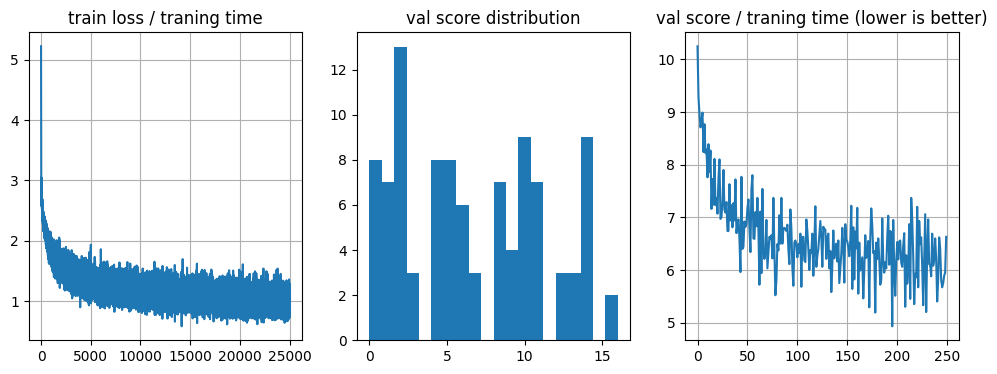

100%|██████████| 25000/25000 [47:11<00:00,  8.83it/s]

llh=0.980, mean score=5.996


In [21]:

for i in trange(25000):
    loss = compute_loss_on_batch(*sample_batch(train_words,word_to_translation,32))

    #train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.data.numpy()[0])

    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))


__How to interpret the plots:__

* __Train loss__ - that's your model's crossentropy over minibatches. It should go down steadily. Most importantly, it shouldn't be NaN :)
* __Val score distribution__ - distribution of translation edit distance (score) within batch. It should move to the left over time.
* __Val score / training time__ - it's your current mean edit distance. This plot is much whimsier than loss, but make sure it goes below 8 by 2500 steps.


In [22]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

כל אנשי סמיילי -> samili state
קטגוריה:ערוץ 2 -> cantal model
עבודה מהבית -> street corps
פראליה -> frallia
קפלר 42 -> capel 234
קטגוריה:מתאסלמים -> metashlamim
בושמי -> boshmi
לאונרדו -> leonardo
שאמה -> shama
עכברה -> askara


In [23]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)

print("Supervised test score:",np.mean(test_scores))

100%|██████████| 407/407 [00:15<00:00, 26.63it/s]

Supervised test score: 6.164617276360283


## Self-critical policy gradient (2 points)

In this section you'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla policy gradient with a special baseline.

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __negative levenshtein distance__ (since we minimize it). The baseline __b(x)__ represents how well model fares on word __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/scheme.png)


Luckily, we already obtained the required outputs: `model.greedy_translations, model.greedy_mask` and we only need to compute levenshtein using `compute_levenshtein` function.


In [24]:
def compute_reward(input_sequence, translations):
    """ computes sample-wise reward given token ids for inputs and translations """
    distances = list(map(get_distance,
                         inp_voc.to_lines(input_sequence.data.numpy()),
                         out_voc.to_lines(translations.data.numpy())))
    # use negative levenshtein distance so that larger reward means better policy
    return - Variable(torch.FloatTensor(distances))

In [25]:
def scst_objective_on_batch(input_sequence, max_len=MAX_OUTPUT_LENGTH):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_sequence = Variable(torch.LongTensor(inp_voc.to_matrix(input_sequence)))

    # use model to __sample__ symbolic translations given input_sequence
    # мой код
    sample_translations, sample_logp = model.translate(input_sequence, greedy=False, max_len=max_len)
    # use model to __greedy__ symbolic translations given input_sequence
    # мой код
    greedy_translations, greedy_logp = model.translate(input_sequence, greedy=True, max_len=max_len)

    #compute rewards and advantage
    rewards = compute_reward(input_sequence, sample_translations)
    # мой код
    baseline = compute_reward(input_sequence, greedy_translations)

    # compute advantage using rewards and baseline
    # мой код
    advantage = rewards - baseline

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(sample_logp * to_one_hot(sample_translations, len(out_voc)), dim=-1)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:,None]

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, out_voc.eos_ix)
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    # мой код
    entropy = - torch.sum(torch.exp(sample_logp)*sample_logp,dim = -1)

    assert entropy.dim() == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

# Policy gradient training


In [26]:
entropy_history = [np.nan] * len(loss_history)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

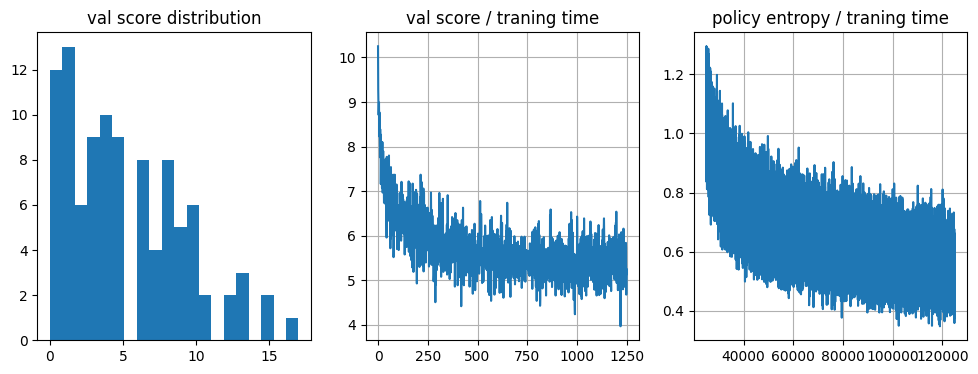

100%|██████████| 100000/100000 [4:15:24<00:00,  6.53it/s]

J=-0.505, mean score=5.331


In [27]:
for i in trange(100000):
    loss, ent = scst_objective_on_batch(sample_batch(train_words,word_to_translation,32)[0])
    # print(loss.data)
    #train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()


    loss_history.append(loss.data.numpy())
    entropy_history.append(ent.data.numpy())

    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(132)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(133)
        plt.title('policy entropy / traning time')
        plt.plot(entropy_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))

### Results

In [28]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

כל אנשי סמיילי -> samil sini
קטגוריה:ערוץ 2 -> hen ari
עבודה מהבית -> alia
פראליה -> pralaia
קפלר 42 -> capeler 24
קטגוריה:מתאסלמים -> mataslamis
בושמי -> boshmi
לאונרדו -> leonardo
שאמה -> shama
עכברה -> akara


In [29]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
print("Supervised test score:",np.mean(test_scores))

# ^^ If you get Out Of MemoryError, please replace this with batched computation

100%|██████████| 407/407 [00:15<00:00, 26.29it/s]

Supervised test score: 5.373501383338457
